In [2]:
import zipfile
import os

zip_path = "/content/FinalProjectData.zip"
extract_path = "/content/FinalProjectData"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data extraction complete.")

Data extraction complete.


In [31]:
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

DATA_DIR = "/content/FinalProjectData"


# Method to convert folder names to class names
def get_class_from_folder(folder_name):
    folder_number = int(folder_name[6:])
    if 1 <= folder_number <= 10:
        return folder_number - 1  # Map to 0-9
    elif 11 <= folder_number <= 36:
        return folder_number -11 + 10 # Map to 10-35 for 'A'-'Z'
    elif 37 <= folder_number <= 62:
        return folder_number -37+ 36 # Map to 36-61 for 'a'-'z'


def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    folders = sorted(os.listdir(data_dir))

    for folder_name in folders:
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):

                class_label = get_class_from_folder(folder_name)
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)

                    # Load and preprocess image
                    image = Image.open(image_path).convert('L')  # Convert to grayscale
                    image = image.resize((80, 60))
                    image_array = np.array(image).flatten() / 255.0  # Normalize

                    images.append(image_array)
                    labels.append(class_label)

    return np.array(images), np.array(labels)


images, labels = load_and_preprocess_images(DATA_DIR)

In [5]:
print(images.shape)
print(labels.shape)

(3410, 4800)
(3410,)


In [6]:
from collections import defaultdict

def split_data(images, labels, num_train=50, num_test=5):
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    class_dict = defaultdict(list)
    for image, label in zip(images, labels):
        class_dict[label].append(image)

    # Split data for each class
    for label, class_images in class_dict.items():
        np.random.shuffle(class_images)  # Shuffle the images randomly

        train_images.extend(class_images[:num_train])
        train_labels.extend([label] * num_train)
        test_images.extend(class_images[num_train:num_train + num_test])
        test_labels.extend([label] * num_test)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = split_data(images, labels)

print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Testing set: {test_images.shape}, {test_labels.shape}")


Training set: (3100, 4800), (3100,)
Testing set: (310, 4800), (310,)


In [18]:
# Using Xavier initialization for assigning weights
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(71)
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(1 / input_size)
    b1 = np.ones((hidden_size, 1))  # Initialize biases to 1
    W2 = np.random.randn(output_size, hidden_size) * np.sqrt(1 / hidden_size)
    b2 = np.ones((output_size, 1))

    return W1, b1, W2, b2

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):

    # Input to hidden layer
    Z1 = np.dot(W1, X.T) + b1
    A1 = sigmoid(Z1)

    # Hidden to output layer
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    return A1, A2, Z1, Z2


In [19]:
# Derivative of sigmoid function
def sigmoid_derivative(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

# Backward propagation
def backward_propagation(X, Y, W1, b1, W2, b2, A1, A2, Z1):
    m = X.shape[0]

    # Output to Hidden
    dZ2 = A2 - Y.T
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden to Input
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * sigmoid_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2


# Update parameters using gradient descent
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    return W1, b1, W2, b2


In [20]:
# Using Binary Cross Entropy Loss
def compute_cost(A2, Y):

    m = Y.shape[0]
    epsilon = 1e-8  # Small value to prevent log(0)
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)  # Clip A2 to avoid log(0)
    cost = -np.sum(Y * np.log(A2_clipped.T) + (1 - Y) * np.log(1 - A2_clipped.T)) / m
    return cost


In [23]:
# Cliiping Gradients
def clip_gradients(dW1, db1, dW2, db2, max_norm=1.0):

    total_norm = np.sqrt(
        np.sum(np.square(dW1)) +
        np.sum(np.square(db1)) +
        np.sum(np.square(dW2)) +
        np.sum(np.square(db2))
    )

    if total_norm > max_norm:
        scale = max_norm / total_norm
        dW1 *= scale
        db1 *= scale
        dW2 *= scale
        db2 *= scale

    return dW1, db1, dW2, db2


In [25]:
def train(train_images, train_labels, input_size, hidden_size, output_size, epochs, learning_rate, batch_size):

    # Initialize parameters
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    # Convert labels to one-hot encoding
    Y_train = np.zeros((train_labels.size, output_size))
    Y_train[np.arange(train_labels.size), train_labels] = 1

    m = train_images.shape[0]

    # Training loop
    for epoch in range(epochs):
        # Shuffle data at the start of each epoch
        indices = np.arange(m)
        np.random.shuffle(indices)
        shuffled_images = train_images[indices]
        shuffled_labels = Y_train[indices]

        # Mini-batch training
        for i in range(0, m, batch_size):

            X_batch = shuffled_images[i:i + batch_size]
            Y_batch = shuffled_labels[i:i + batch_size]

            # Forward propagation
            A1, A2, Z1, Z2 = forward_propagation(X_batch, W1, b1, W2, b2)

            # Computing cost
            cost = compute_cost(A2, Y_batch)

            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_batch, Y_batch, W1, b1, W2, b2, A1, A2, Z1)

            # Clip gradients
            dW1, db1, dW2, db2 = clip_gradients(dW1, db1, dW2, db2, max_norm=1.0)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Evaluate cost after epoch
        A1, A2, _, _ = forward_propagation(train_images, W1, b1, W2, b2)
        epoch_cost = compute_cost(A2, Y_train)

        # Print cost and accuracy every 10 epochs
        if epoch % 10 == 0 or epoch == epochs - 1:

            predictions = np.argmax(A2, axis=0)
            accuracy = np.mean(predictions == train_labels) * 100
            print(f"Epoch {epoch + 1}/{epochs}, Cost: {epoch_cost:.4f}, Accuracy: {accuracy:.2f}%")

    return W1, b1, W2, b2


In [26]:
# Hyperparameters
input_size = 4800
hidden_size = 100
output_size = 62
epochs = 2000
learning_rate = 0.01
batch_size = 32


W1, b1, W2, b2 = train(train_images, train_labels, input_size, hidden_size, output_size, epochs, learning_rate, batch_size)

Epoch 1/2000, Cost: 38.3125, Accuracy: 1.61%
Epoch 11/2000, Cost: 5.1184, Accuracy: 1.97%
Epoch 21/2000, Cost: 5.1158, Accuracy: 2.29%
Epoch 31/2000, Cost: 5.1112, Accuracy: 2.13%
Epoch 41/2000, Cost: 5.1026, Accuracy: 4.65%
Epoch 51/2000, Cost: 5.0897, Accuracy: 5.06%
Epoch 61/2000, Cost: 5.0714, Accuracy: 5.23%
Epoch 71/2000, Cost: 5.0466, Accuracy: 9.16%
Epoch 81/2000, Cost: 5.0188, Accuracy: 11.45%
Epoch 91/2000, Cost: 4.9862, Accuracy: 13.87%
Epoch 101/2000, Cost: 4.9491, Accuracy: 15.97%
Epoch 111/2000, Cost: 4.9077, Accuracy: 16.55%
Epoch 121/2000, Cost: 4.8632, Accuracy: 17.32%
Epoch 131/2000, Cost: 4.8153, Accuracy: 18.65%
Epoch 141/2000, Cost: 4.7681, Accuracy: 20.10%
Epoch 151/2000, Cost: 4.7193, Accuracy: 20.81%
Epoch 161/2000, Cost: 4.6691, Accuracy: 23.55%
Epoch 171/2000, Cost: 4.6215, Accuracy: 23.29%
Epoch 181/2000, Cost: 4.5734, Accuracy: 24.35%
Epoch 191/2000, Cost: 4.5270, Accuracy: 24.61%
Epoch 201/2000, Cost: 4.4819, Accuracy: 26.00%
Epoch 211/2000, Cost: 4.4374, A

In [27]:
# Evaluate on testing data

_, A2, _, _ = forward_propagation(test_images, W1, b1, W2, b2)
predictions = np.argmax(A2, axis=0)
test_accuracy = np.mean(predictions == test_labels) * 100

print(f"Testing Accuracy: {test_accuracy:.2f}%")

Testing Accuracy: 43.55%


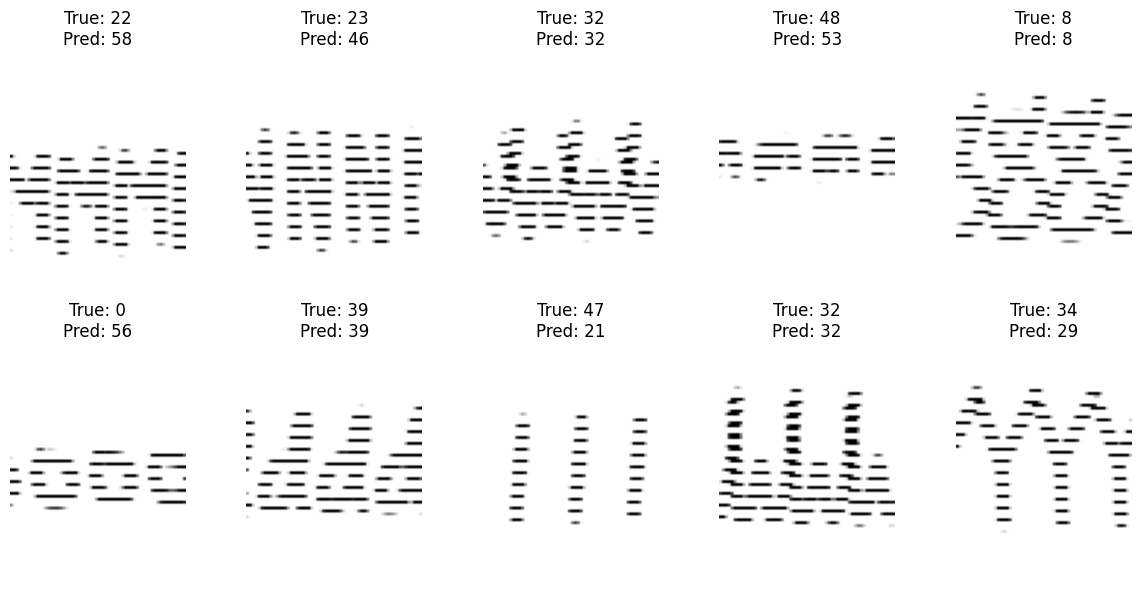

In [34]:
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(test_images), size=10, replace=False)

plt.figure(figsize=(12, 6))
for idx, i in enumerate(random_indices):
    plt.subplot(2, 5, idx + 1)  # Adjust for 2 rows, 5 columns
    image = test_images[i].reshape(80, 60)  # Ensure each image is correctly reshaped
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {test_labels[i]}\nPred: {predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()